In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# On policy first-visit MC control

Algorytm testowany będzie w ramach próby znalezienia polityki służącej do przechodzenia labiryntu 8x8
Początkowym stanem będzie pozycja (0,0), końcowym - (7,7). W przypadku ruchu 'w ścianę' pozycja agenta nie zmienia się.
Dopuszczalne ruchy to góra, dół, lewo i prawo.

Akcje

In [5]:
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

In [6]:
def is_valid_move(maze, pos):
    x, y = pos
    if x < 0 or x == 8 or y < 0 or y == 8 or maze[x, y] == 1:
        return False
    return True

Pojedynczy epizod

In [7]:
def episode_generator(policy):
    episode = []
    current_state = (0,0)
    
    while current_state != end_position:
        action_probabilities = policy[current_state]
        idx = np.random.choice(4, p=action_probabilities)
        action = actions[idx]
        next_state = (current_state[0] + action[0], current_state[1] + action[1])
        
        if is_valid_move(maze, next_state):
            if next_state == end_position:
                reward = 0  
            else:
                reward = -1
            episode.append((current_state, idx, reward))
        else:
            episode.append((current_state, idx, -1))
            next_state = current_state
            
        current_state = next_state
    return episode

# Algorytm

In [8]:
def on_policy_first_visit_mc_control(maze, epsilon, max_episodes=5000000):
    policy = {}
    Q = {}
    returns = {}
    
    for i in range(8):
        for j in range(8):
            if maze[i, j] == 0:
                state = (i, j)
                policy[state] = [1 / 4] * 4
                Q[state] = [0] * 4
                returns[state] = [[] for _ in range(4)]
    stable_policy_counter = 0
    for episode_num in range(max_episodes):
        if stable_policy_counter >= 100:
            break
        episode = episode_generator(policy)
        G = 0
        visited_state_action_pairs = set()
        policy_changed = False
        
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G += reward
            if (state, action) not in visited_state_action_pairs:
                visited_state_action_pairs.add((state, action))
                returns[state][action].append(G)
                Q[state][action] = np.mean(returns[state][action])
                best_action = np.argmax(Q[state])
                best_actions = [a for a in range(4) if Q[state][a] == max(Q[state])]
                if len(best_actions) == 4:
                    policy[state] = [1/4] * 4
                else:
                    for a in range(4):
                        if a in best_actions:
                            policy[state][a] = (1 - epsilon)/len(best_actions)
                        else:
                            policy[state][a] = epsilon/(4-len(best_actions))
                if np.argmax(policy[state]) != best_action:
                    stable_policy_counter = 0
        
        if policy_changed:
            stable_policy_counter = 0
        else:
            stable_policy_counter += 1
    return episode_num

# Labirynt

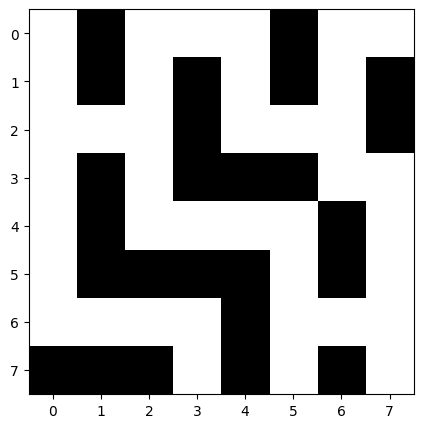

In [9]:
maze = np.array([
    [0, 1, 0, 0, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 1, 1, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 1, 0]
])
start_position = (0, 0)
end_position = (7, 7)

plt.figure(figsize=(5, 5))
plt.imshow(maze, cmap='binary')
plt.show()

# Rozwiązanie

Text(0.5, 1.0, 'Wplyw parametru Epsilon na liczbe krokow wymaganych do zbieznosci')

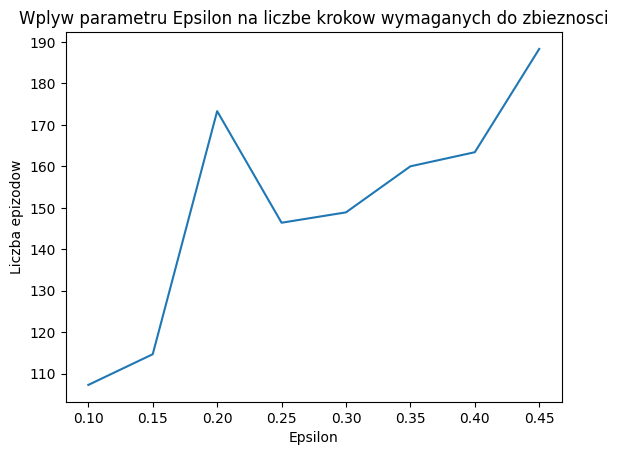

In [11]:
epsilon_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
results = []

for epsilon in epsilon_values:
    curr_results = []
    for _ in range(50):
        curr_results.append(on_policy_first_visit_mc_control(maze, epsilon))
    results.append(np.mean(curr_results) + 1)

plt.plot(epsilon_values, results)
plt.xlabel('Epsilon')
plt.ylabel('Liczba epizodow')
plt.title('Wplyw parametru Epsilon na liczbe krokow wymaganych do zbieznosci')